# Part 2

1. 딥러닝 기법인 Word2Vec을 통해 단어를 벡터화 해본다.
2. t-SNE를 통해 벡터화한 데이터를 시각화 해본다.
3. 딥러닝과 지도학습의 랜덤포레스트를 사용하는 하이브리드 방식을 사용한다.

### Word2Vec(Word Embedding to Vector)

컴퓨터는 숫자만 인식할 수 있고 한글, 이미지는 바이너리 코드로 저장 된다. tutorial_part_1에서는 Bag of Word라는 개념을 사용해서 문자를 벡터화 하여 머신러닝 알고리즘이 이해할 수 있도록 벡터화 해주는 작업을 하였다.

- one hot encoding(예 [0000001000]) 혹은 Bag of Word에서 vector size가 매우 크고 sparse 하므로 neural net 성능이 잘 나오지 않는다.
- `주위 단어가 비슷하면 해당 단어의 의미는 유사하다` 라는 아이디어
- 단어를 트레이닝 시킬 때 주위 단어를 label로 매치하여 최적화
- 단어를 `의미를 내포한 dense vector`로 매칭 시키는 것
- Word2Vec은 분산 된 텍스트 표현을 사용하여 개념 간 유사성을 본다. 예를 들어, 파리와 프랑스가 베를린과 독일이 (수도와 나라) 같은 방식으로 관련되어 있음을 이해한다.
- 단어의 임베딩과정을 실시간으로 시각화 : [word embedding visual inspector](https://ronxin.github.io/wevi/)
- CBOW와 Skip-Gram기법이 있다.
    - CBOW(continuous bag-of-words)는 전체 텍스트로 하나의 단어를 예측하기 때문에 작은 데이터셋일 수록 유리하다.
    - 아래 예제에서 __ 에 들어갈 단어를 예측한다.

        1) __가 맛있다. 
        
        2) __를 타는 것이 재미있다. 
        
        3) 평소보다 두 \__로 많이 먹어서 \__가 아프다. 
           
    - Skip-Gram은 타겟 단어들로부터 원본 단어를 역으로 예측하는 것이다. CBOW와는 반대로 컨텍스트-타겟 쌍을 새로운 발견으로 처리하고 큰 규모의 데이터셋을 가질 때 유리하다.
    - `배`라는 단어 주변에 올 수 있는 단어를 예측한다.

        1) *배*가 맛있다.
        
        2) *배*를 타는 것이 재미있다. 
        
        3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.

In [1]:
# 출력이 너무 길어지지 않게하기 위해 warning을 찍지 않도록 했으나 
# 실제 학습 할 때는 아래 두 줄을 주석처리 하는 것을 권장한다.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

train = pd.read_csv('data/labeledTrainData.tsv', 
                    header=0, delimiter='\t', quoting=3)
test = pd.read_csv('data/testData.tsv', 
                   header=0, delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('data/unlabeledTrainData.tsv', 
                              header=0, delimiter='\t', quoting=3)

print(train.shape)
print(test.shape)
print(unlabeled_train.shape)

print(train['review'].size)
print(test['review'].size)
print(unlabeled_train['review'].size)

(25000, 3)
(25000, 2)
(50000, 2)
25000
25000
50000


In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
# train에 있는 평점정보인 sentiment가 없다.
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [6]:
# tutorial_part_1에서 수행한 것을 python파일로 만들어 쉽게 호출해서 사용
from KaggleWord2VecUtility import KaggleWord2VecUtility as KWVU
KWVU.review_to_wordlist(train['review'][0])[:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [7]:
# train 데이터 전처리
sentences = []
for review in train["review"]:
    sentences += KWVU.review_to_sentences(
        review, remove_stopwords=False)

In [8]:
# unlabeled_train 데이터 전처리
for review in unlabeled_train["review"]:
    sentences += KWVU.review_to_sentences(
        review, remove_stopwords=False)

In [ ]:
len(sentences)

In [ ]:
sentences[0][:10]

In [ ]:
sentences[1][:10]

## 1. Word2Vec 모델을 학습

전처리를 거쳐 파싱된 문장을 목록으로 모델을 학습시킬 준비가 됨.

단어 간 문맥의 의미를 파악하기 위해서 Stopwords를 제거 하지 않음.

### Gensim
- [gensim: models.word2vec – Deep learning with word2vec](https://radimrehurek.com/gensim/models/word2vec.html)

### Word2Vec 모델의 parameter

- 아키텍처 : 아키텍처 옵션은 skip-gram (default) 또는 CBOW 모델이다. skip-gram (default)은 느리지 만 더 나은 결과를 낸다.

- 학습 알고리즘 : Hierarchical softmax (default) 또는 negative 샘플링. 여기에서는 기본값이 잘 동작한다.

- 빈번하게 등장하는 단어에 대한 다운 샘플링 : Google 문서는 .00001에서 .001 사이의 값을 권장한다. 여기에서는 0.001에 가까운 값이 최종 모델의 정확도를 높이는 것으로 보여진다.

- 단어 벡터 차원 : 많은 feature를 사용한다고 항상 좋은 것은 아니지만 대체적으로 좀 더 나은 모델이 된다. 합리적인 값은 수십에서 수백 개가 될 수 있고 여기에서는 300으로 지정했다.

- 컨텍스트 / 창 크기 : 학습 알고리즘이 고려해야하는 컨텍스트의 단어 수는 얼마나 될까? hierarchical softmax 를 위해 좀 더 큰 수가 좋지만 10 정도가 적당하다.

- Worker threads : 실행할 병렬 프로세스의 수로 컴퓨터마다 다르지만 대부분의 시스템에서 4에서 6 사이의 값을 사용하다.

- 최소 단어 수 : 어휘의 크기를 의미있는 단어로 제한하는 데 도움이 된다. 모든 문서에서이 여러 번 발생하지 않는 단어는 무시된다. 10에서 100 사이가 적당하며, 이 경진대회의 데이터는 각 영화가 30개씩의 리뷰가 있기 때문에 개별 영화 제목에 너무 많은 중요성이 붙는 것을 피하기 위해 최소 단어 수를 40으로 설정한다. 그 결과 전체 어휘 크기는 약 15,000 단어가 된다. 높은 값은 제한 된 실행시간에 도움이 된다.

In [9]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [11]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2018-04-19 14:26:23,996 : INFO : 'pattern' package not found; tag filters are not available for English
2018-04-19 14:26:24,005 : INFO : collecting all words and their counts
2018-04-19 14:26:24,005 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-19 14:26:24,111 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 12465 word types
2018-04-19 14:26:24,199 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 17070 word types
2018-04-19 14:26:24,293 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 20370 word types
2018-04-19 14:26:24,380 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 23125 word types
2018-04-19 14:26:24,478 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 25365 word types
2018-04-19 14:26:24,564 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 27283 word types
2018-04-19 14:26:24,702 : INFO : PROGRESS: at senten

2018-04-19 14:26:32,066 : INFO : PROGRESS: at sentence #710000, processed 15880371 words, keeping 82560 word types
2018-04-19 14:26:32,177 : INFO : PROGRESS: at sentence #720000, processed 16105658 words, keeping 83036 word types
2018-04-19 14:26:32,279 : INFO : PROGRESS: at sentence #730000, processed 16332039 words, keeping 83571 word types
2018-04-19 14:26:32,382 : INFO : PROGRESS: at sentence #740000, processed 16553072 words, keeping 84127 word types
2018-04-19 14:26:32,497 : INFO : PROGRESS: at sentence #750000, processed 16771399 words, keeping 84599 word types
2018-04-19 14:26:32,609 : INFO : PROGRESS: at sentence #760000, processed 16990803 words, keeping 85068 word types
2018-04-19 14:26:32,719 : INFO : PROGRESS: at sentence #770000, processed 17217940 words, keeping 85644 word types
2018-04-19 14:26:32,828 : INFO : PROGRESS: at sentence #780000, processed 17448086 words, keeping 86160 word types
2018-04-19 14:26:32,930 : INFO : PROGRESS: at sentence #790000, processed 176751

2018-04-19 14:27:21,998 : INFO : EPOCH 3 - PROGRESS: at 14.83% examples, 615118 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:27:23,001 : INFO : EPOCH 3 - PROGRESS: at 19.55% examples, 610682 words/s, in_qsize 8, out_qsize 0
2018-04-19 14:27:24,009 : INFO : EPOCH 3 - PROGRESS: at 24.56% examples, 616207 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:27:25,018 : INFO : EPOCH 3 - PROGRESS: at 29.76% examples, 624370 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:27:26,023 : INFO : EPOCH 3 - PROGRESS: at 35.10% examples, 631394 words/s, in_qsize 8, out_qsize 0
2018-04-19 14:27:27,029 : INFO : EPOCH 3 - PROGRESS: at 40.41% examples, 637689 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:27:28,037 : INFO : EPOCH 3 - PROGRESS: at 45.71% examples, 642420 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:27:29,043 : INFO : EPOCH 3 - PROGRESS: at 50.28% examples, 637095 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:27:30,050 : INFO : EPOCH 3 - PROGRESS: at 54.26% examples, 625581 words/s, in_qsiz

2018-04-19 14:28:28,692 : INFO : EPOCH 5 - PROGRESS: at 62.18% examples, 567320 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:28:29,700 : INFO : EPOCH 5 - PROGRESS: at 67.06% examples, 571029 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:28:30,707 : INFO : EPOCH 5 - PROGRESS: at 71.65% examples, 572097 words/s, in_qsize 8, out_qsize 0
2018-04-19 14:28:31,721 : INFO : EPOCH 5 - PROGRESS: at 76.60% examples, 575319 words/s, in_qsize 7, out_qsize 1
2018-04-19 14:28:32,727 : INFO : EPOCH 5 - PROGRESS: at 81.15% examples, 575651 words/s, in_qsize 8, out_qsize 0
2018-04-19 14:28:33,731 : INFO : EPOCH 5 - PROGRESS: at 85.05% examples, 571879 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:28:34,748 : INFO : EPOCH 5 - PROGRESS: at 89.15% examples, 569172 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:28:35,757 : INFO : EPOCH 5 - PROGRESS: at 93.68% examples, 569650 words/s, in_qsize 7, out_qsize 0
2018-04-19 14:28:36,762 : INFO : EPOCH 5 - PROGRESS: at 98.56% examples, 572203 words/s, in_qsiz

In [12]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
# model_name = '300features_50minwords_20text'
model.save(model_name)

2018-04-19 14:29:00,232 : INFO : precomputing L2-norms of word weight vectors
2018-04-19 14:29:00,408 : INFO : saving Word2Vec object under 300features_40minwords_10text, separately None
2018-04-19 14:29:00,410 : INFO : not storing attribute vectors_norm
2018-04-19 14:29:00,412 : INFO : not storing attribute cum_table
2018-04-19 14:29:01,131 : INFO : saved 300features_40minwords_10text


## 모델 결과 탐색
Exploring the Model Results

In [13]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [14]:
model.wv.doesnt_match("france england germany berlin".split())

2018-04-19 14:29:10,605 : WARNING : vectors for words {'france', 'germany'} are not present in the model, ignoring these words


'england'

In [15]:
# 가장 유사한 단어를 추출
model.wv.most_similar("man")

[('woman', 0.6483475565910339),
 ('businessman', 0.5279209613800049),
 ('lad', 0.5071824789047241),
 ('ladi', 0.5070064067840576),
 ('millionair', 0.49874261021614075),
 ('loner', 0.4921835660934448),
 ('boxer', 0.47740548849105835),
 ('billionair', 0.4695820212364197),
 ('men', 0.46570345759391785),
 ('doctor', 0.46422839164733887)]

In [16]:
model.wv.most_similar("queen")

[('princess', 0.6150144338607788),
 ('victoria', 0.557492733001709),
 ('goddess', 0.5567865967750549),
 ('bride', 0.5552693605422974),
 ('maid', 0.5422271490097046),
 ('stepmoth', 0.5346044898033142),
 ('mistress', 0.5310652852058411),
 ('latifah', 0.5263130068778992),
 ('princ', 0.5261605978012085),
 ('antoinett', 0.5249156951904297)]

In [19]:
# vocabulary에 없으면 못 찾음
model.wv.most_similar("awful")

KeyError: "word 'awful' not in vocabulary"

In [17]:
model.wv.most_similar("film")

[('movi', 0.8502352237701416),
 ('flick', 0.6033400297164917),
 ('documentari', 0.5686618089675903),
 ('pictur', 0.5474764704704285),
 ('cinema', 0.5144171714782715),
 ('it', 0.49581414461135864),
 ('genr', 0.47876858711242676),
 ('sequel', 0.4787057936191559),
 ('masterpiec', 0.47783994674682617),
 ('effort', 0.47280365228652954)]

In [18]:
# model.wv.most_similar("happy")
model.wv.most_similar("happi") # stemming 처리 시

[('unhappi', 0.4360881447792053),
 ('bitter', 0.4267476201057434),
 ('satisfi', 0.42120903730392456),
 ('sad', 0.4064207375049591),
 ('happier', 0.388952374458313),
 ('glad', 0.3858465552330017),
 ('afraid', 0.37603798508644104),
 ('lucki', 0.3672526180744171),
 ('comfort', 0.36415570974349976),
 ('uplift', 0.3596024215221405)]

## 2. Word2Vec으로 벡터화한 단어를 t-SNE를 통해 시각화

In [20]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

2018-04-19 14:39:25,061 : INFO : loading Doc2Vec object from 300features_40minwords_10text
2018-04-19 14:39:25,496 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2018-04-19 14:39:25,497 : INFO : setting ignored attribute vectors_norm to None
2018-04-19 14:39:25,498 : INFO : loading vocabulary recursively from 300features_40minwords_10text.vocabulary.* with mmap=None
2018-04-19 14:39:25,498 : INFO : loading trainables recursively from 300features_40minwords_10text.trainables.* with mmap=None
2018-04-19 14:39:25,503 : INFO : setting ignored attribute cum_table to None
2018-04-19 14:39:25,507 : INFO : loaded 300features_40minwords_10text


11986
[ 0.00557014 -0.03104194  0.03236469 -0.05233081  0.04477278 -0.10004187
  0.03866708 -0.06265384  0.05395063  0.02252266]


In [21]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [22]:
df.head(10)

,x,y
with,3.231965,-4.287191
all,2.335387,0.911480
this,0.884680,0.883098
stuff,4.983868,0.864961
go,-2.954497,-3.035274
down,5.195068,-6.195749
at,3.169314,-5.870075
the,3.059186,-0.680368
moment,6.677357,5.061613
mj,9.075441,0.318720


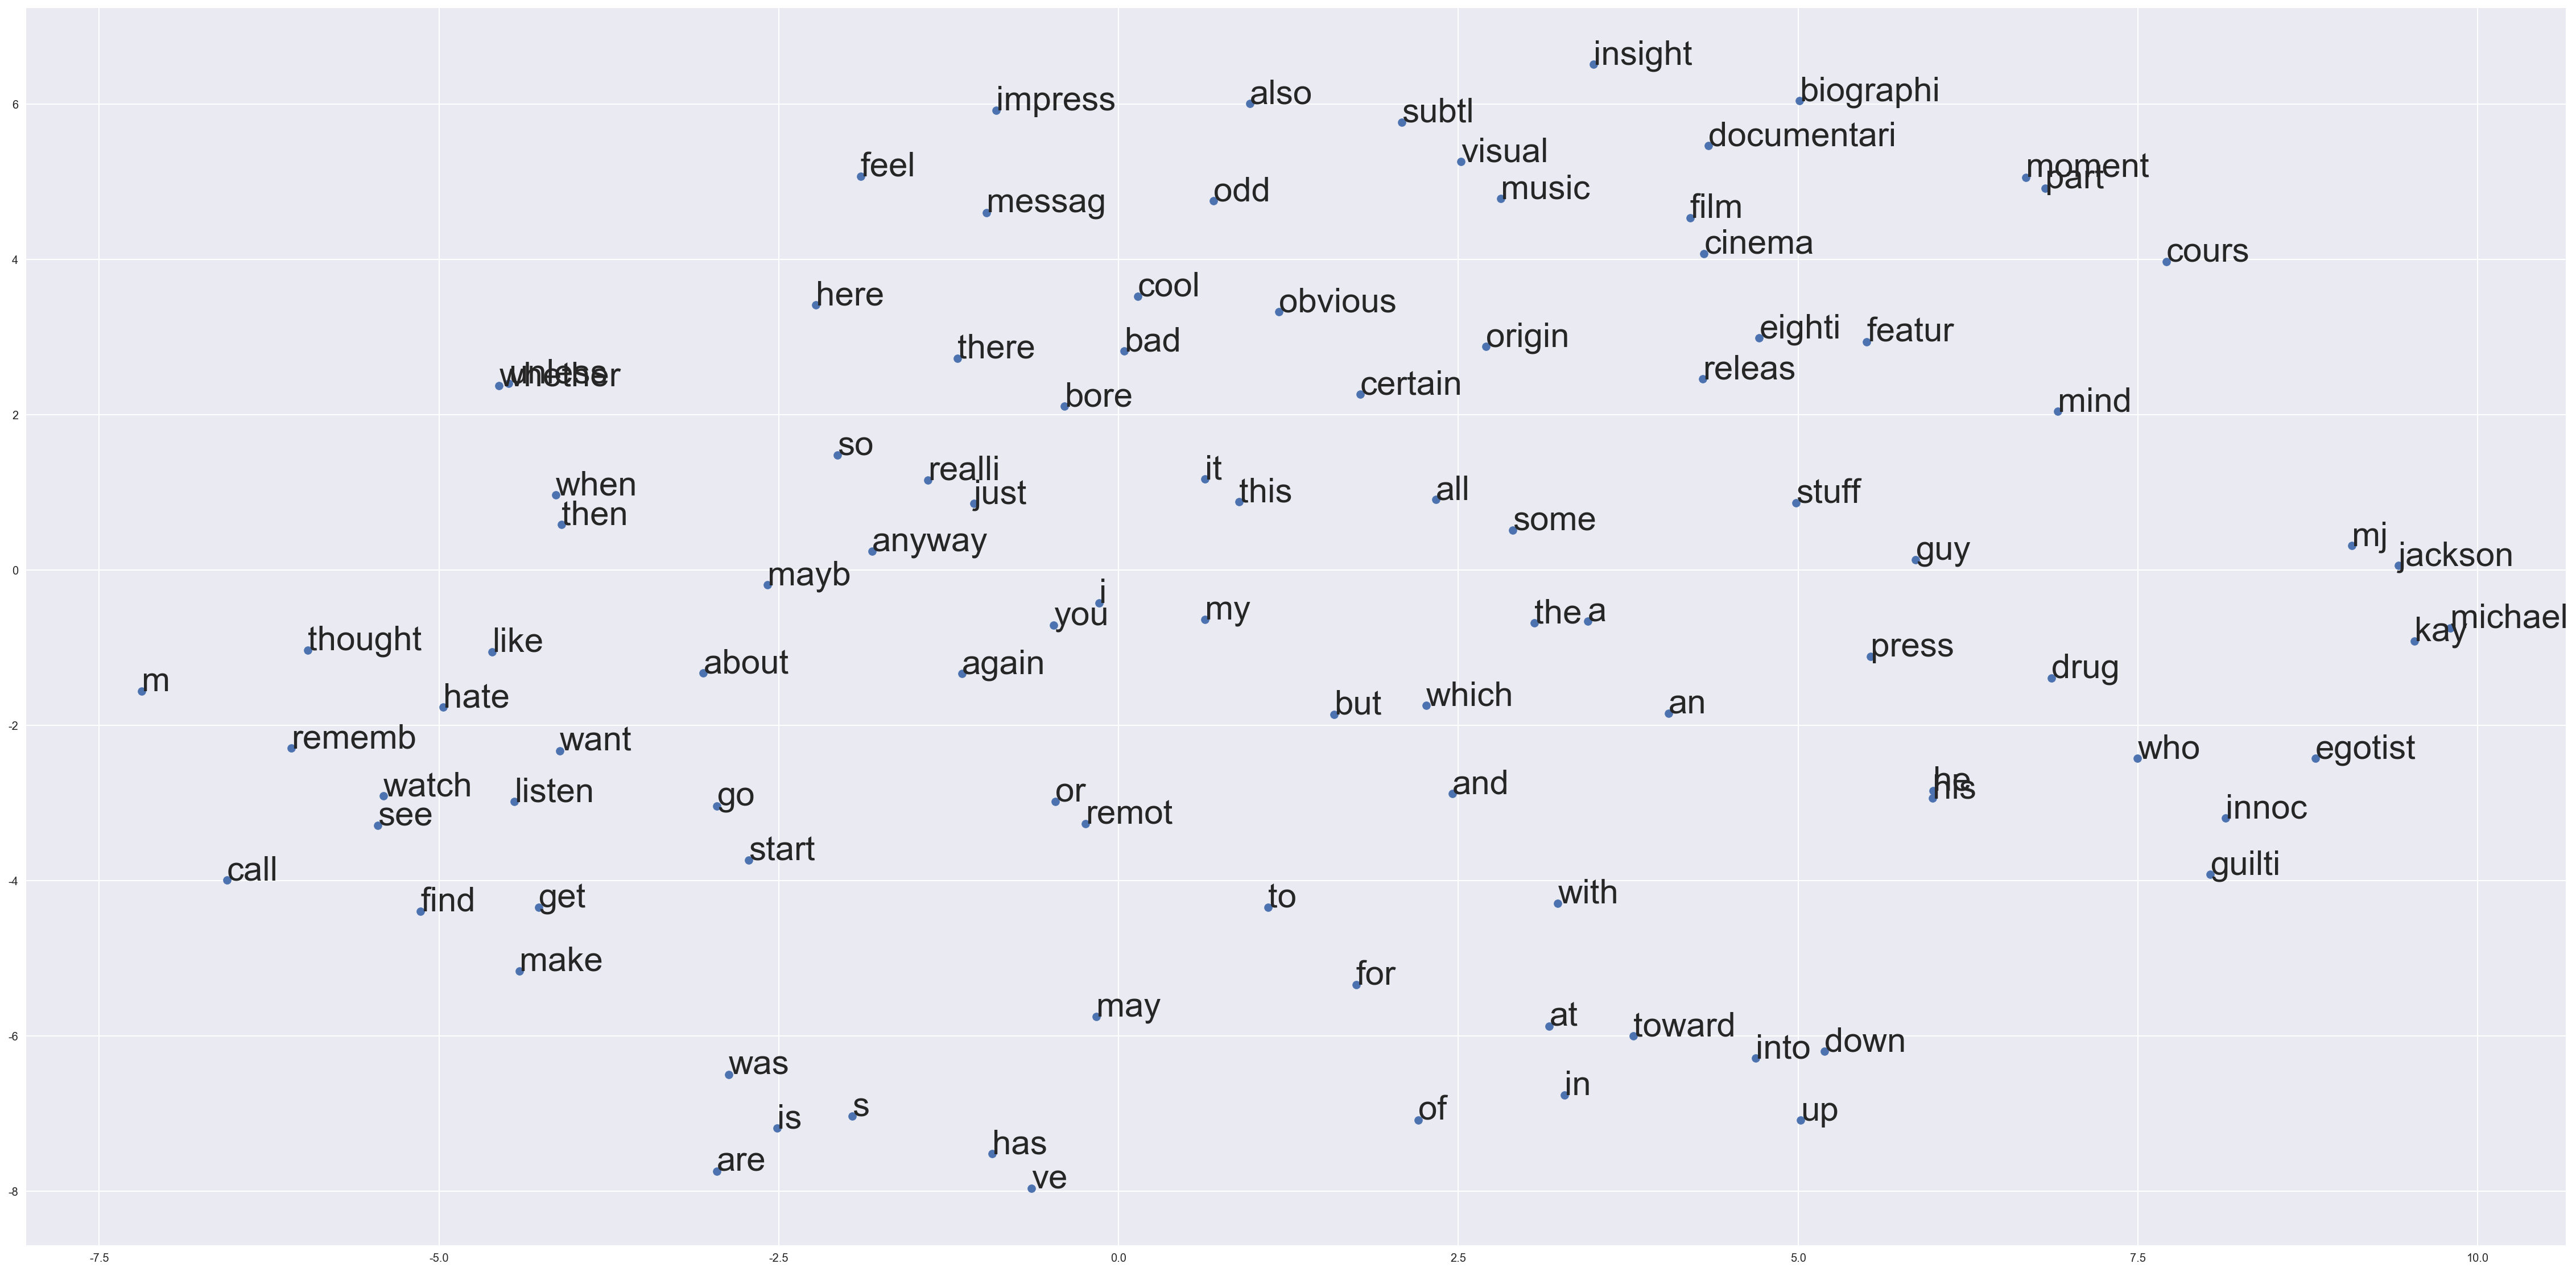

In [23]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

## 3. 평균 feature vector 구하기 및 랜덤포레스트 학습

In [24]:
import numpy as np

def makeFeatureVec(words, model, num_features):
    """
    주어진 문장에서 단어 벡터의 평균을 구하는 함수
    """
    # 속도를 위해 0으로 채운 배열로 초기화 한다.
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    
    # Index2word는 모델의 사전에 있는 단어명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화 한다.
    index2word_set = set(model.wv.index2word)
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 결과를 단어수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [25]:
def getAvgFeatureVecs(reviews, model, num_features):
    # 리뷰 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환한다.
    
    # 카운터를 초기화 한다.
    counter = 0.
    
    # 속도를 위해 2D 넘파이 배열을 미리 할당한다.
    reviewFeatureVecs = np.zeros(
        (len(reviews),num_features),dtype="float32")
    
    for review in reviews:
       # 매 1000개 리뷰마다 상태를 출력
       if counter % 1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
       # 평균 피처 벡터를 만들기 위해 위에서 정의한 함수를 호출한다.
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       # 카운터를 증가시킨다.
       counter = counter + 1.
    return reviewFeatureVecs

In [26]:
# 멀티스레드로 4개의 워커를 사용해 처리한다.
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = KWVU.apply_by_multiprocessing(\
        reviews["review"], KWVU.review_to_wordlist,\
        workers=4)
    return clean_reviews

In [27]:
%time trainDataVecs = getAvgFeatureVecs(\
    getCleanReviews(train), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 33s, sys: 6.26 s, total: 1min 39s
Wall time: 3min 4s


In [28]:
%time testDataVecs = getAvgFeatureVecs(\
        getCleanReviews(test), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 16s, sys: 1.96 s, total: 1min 18s
Wall time: 2min 26s


In [29]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

In [30]:
# 랜덤포레스트로 학습시키기
%time forest = forest.fit( trainDataVecs, train["sentiment"] )

CPU times: user 1min 4s, sys: 338 ms, total: 1min 4s
Wall time: 18.5 s


In [31]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, trainDataVecs, \
    train['sentiment'], cv=10, scoring='roc_auc'))

CPU times: user 9min 30s, sys: 3.47 s, total: 9min 33s
Wall time: 2min 53s


In [32]:
score

0.9055806079999998

In [33]:
result = forest.predict(testDataVecs)

In [34]:
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv('data/Word2Vec_AverageVectors_{0:.5f}.csv'.format(score), 
              index=False, quoting=3 )

In [35]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

20


0    12510
1    12490
Name: sentiment, dtype: int64

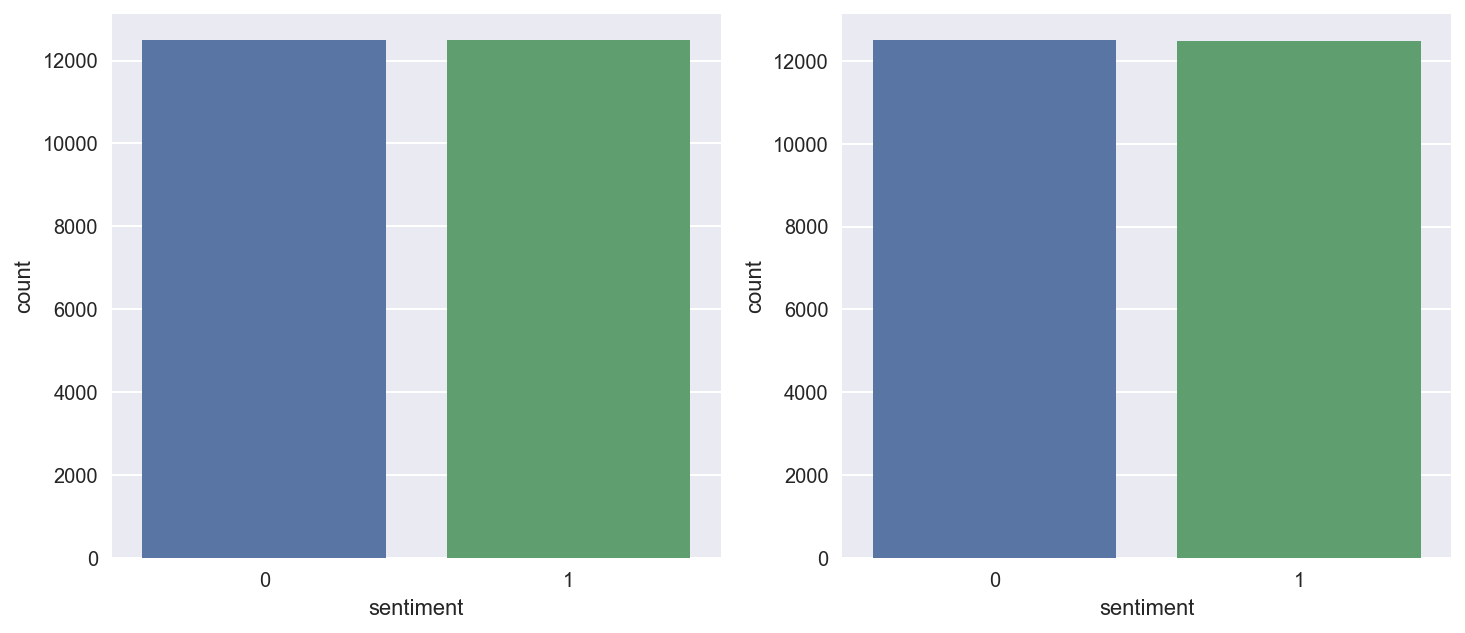

In [36]:
import seaborn as sns 
%matplotlib inline

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [38]:
print(round(540/578*100, 2), "%")

93.43 %
